В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.tree import plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import time

In [2]:
from process_bank_churn import preprocess_data

In [3]:
raw_df = pd.read_csv('train.csv')

data = preprocess_data(raw_df, scaler_numeric = False)

X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [4]:
# Створення та навчання моделі
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [5]:
# Отримання прогнозів та розрахунок AUROC
train_targets_proba = knn.predict_proba(X_train)[:, 1]
val_targets_proba = knn.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_targets_proba).round(2)
val_auc = roc_auc_score(val_targets, val_targets_proba).round(2)

print("Train AUROC:", train_auc)
print("Validation AUROC:", val_auc)

Train AUROC: 0.82
Validation AUROC: 0.56


З отриманих результатів бачимо, що модель перенавчається (AUROC на трейн даних вище ніж на валідаційних).
Модель потребує покращення

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [6]:
param_grid = {'n_neighbors': np.arange(1, 200)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, train_targets)

best_params = grid_search.best_params_
print("Найкраще значення n_neighbors:", best_params['n_neighbors'])

knn_best = grid_search.best_estimator_

Найкраще значення n_neighbors: 62


In [7]:
# Оцінка на тренувальному наборі
train_targets_proba_best = knn_best.predict_proba(X_train)[:, 1]
train_auc_best = roc_auc_score(train_targets, train_targets_proba_best).round(2)

# Оцінка на валідаційному наборі
val_targets_proba_best = knn_best.predict_proba(X_val)[:, 1]
val_auc_best = roc_auc_score(val_targets, val_targets_proba_best).round(2)

print("Train AUROC:", train_auc_best)
print("Validation AUROC:", val_auc_best)

Train AUROC: 0.65
Validation AUROC: 0.61


На основі отриманих результатів бачимо, що при значенні параметра `n_neighbors = 62` маємо більш рівні показники на тренувальних і валідаційних даних, але загалом AUROC знизився. Тому необхідно далі працювати над моделлю

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [8]:
param_grid = {
    'max_depth': [i for i in range(1, 21, 2)],
    'max_leaf_nodes': [i for i in range(2, 11)]
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc')

start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()
print(f"Час виконання GridSearchCV: {end_time - start_time:.2f} секунд")

Час виконання GridSearchCV: 8.97 секунд


In [9]:
best_params = grid_search.best_params_
print("Найкращі параметри:", best_params)

dt_best = grid_search.best_estimator_

Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 10}


In [10]:
# Оцінка на тренувальному наборі
train_targets_proba_best2 = dt_best.predict_proba(X_train)[:, 1]
train_auc_best2 = roc_auc_score(train_targets, train_targets_proba_best2).round(2)

# Оцінка на валідаційному наборі
val_targets_proba_best2 = dt_best.predict_proba(X_val)[:, 1]
val_auc_best2 = roc_auc_score(val_targets, val_targets_proba_best2).round(2)

print("Train AUROC:", train_auc_best2)
print("Validation AUROC:", val_auc_best2)

Train AUROC: 0.91
Validation AUROC: 0.89


Внаслідок пошуку оптимальних гіперпараметрів ми отримали значно кращі результати ніж в ручному режимі. Також не спостерігаємо пере- чи недонавчання.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [11]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

dt = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(dt, params_dt, n_iter=40, cv=3, scoring='roc_auc', random_state=42)

start_time = time.time()
random_search.fit(X_train, train_targets)
end_time = time.time()
print(f"Час виконання RandomizedSearchCV: {end_time - start_time:.2f} секунд")

Час виконання RandomizedSearchCV: 2.54 секунд


In [12]:
best_params = random_search.best_params_
print("Найкращі параметри:", best_params)

dt_random_search_best = random_search.best_estimator_

Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}


In [13]:
# Оцінка на тренувальному наборі
train_targets_proba_best3 = dt_random_search_best.predict_proba(X_train)[:, 1]
train_auc_best3  = roc_auc_score(train_targets, train_targets_proba_best3).round(2)

# Оцінка на валідаційному наборі
val_targets_proba_best3 = dt_random_search_best.predict_proba(X_val)[:, 1]
val_auc_best3 = roc_auc_score(val_targets, val_targets_proba_best3).round(2)

print("Train AUROC:", train_auc_best3 )
print("Validation AUROC:", val_auc_best3)

Train AUROC: 0.92
Validation AUROC: 0.9


Отримана модель значно краща від попередніх експериментів. 
Також, використовуючи `RandomizedSearchCV` ми майже в четверо скоротили час пошуку кращих гіперпараметрів
`RandomizedSearchCV` дає можливість використовувати більше параметрів для пошуку кращого рішення

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [14]:
new_df = pd.read_csv('test.csv')
from process_bank_churn import preprocess_new_data

X_test = preprocess_new_data(new_df, scaler_numeric = False)
X_test_ = X_test.drop('id', axis=1)

test_preds = dt_random_search_best.predict_proba(X_test_)[:, 1]

# Перетворюємо масив в Series
test_preds_df = pd.DataFrame()
test_preds_df = test_preds_df.assign(Exited=test_preds)

# Об'єднуємо DataFrame и Series
Final = pd.concat([X_test, test_preds_df], axis=1)

#залишаємо для завантаження на Kaggle лише CustomerId і Exited
Final = Final[['id', 'Exited']]

In [15]:
Final.to_csv('submission .csv', index=False)

Мій Score на Leaderbord :-)


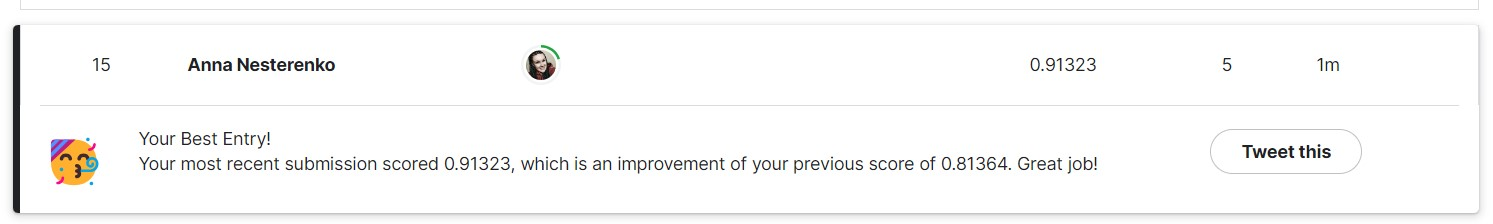

In [17]:
from IPython.display import Image
print('Мій Score на Leaderbord :-)')
Image("Screenshot_2.jpg", width=1320, height=1240) 